<a href="https://colab.research.google.com/github/mtwatso2-eng/ANS128/blob/main/Lab4_ImageAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image analysis**

### Images are arrays!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

array = np.array([
    [[0,255,0],[0,255,0]],
    [[0,255,0],[255,255,255]]
  ])

print(array.shape)

import cv2
from google.colab.patches import cv2_imshow

cv2_imshow(array)

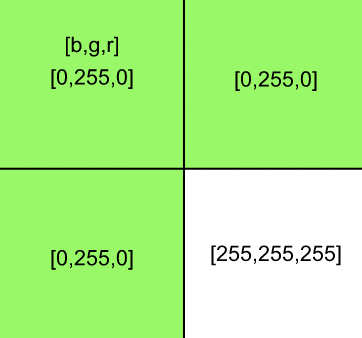

### Question
Using np.array() and cv2_imshow(), display a big red square.

In [ ]:
newArray = np.array([

  ])
cv2_imshow(newArray)

# Simple image manipulation with OpenCV

### Read images from GitHub

In [ ]:
!git clone https://github.com/mtwatso2-eng/ANS128.git

In [ ]:
import os
import matplotlib.pyplot as plt

imageDirectory = "/content/ANS128/data/leaves/"
images = [cv2.imread(imageDirectory + i)[:,:,::-1] for i in sorted(os.listdir(imageDirectory))]
images = [cv2.resize(image, (0,0), fx = 0.25, fy = 0.25) for image in images]
for image in images[0:5]:
  plt.figure()
  plt.imshow(image)
  plt.pause(0.001)

### Question
Get the average B, G, and R values for each image in the images object. *Hint: np.mean(a, axis = x) gets the mean of a across axis/axes x. Axis/axes x can be a tuple.*

# Object segmentation with K-means clustering

### What is K-means clustering?

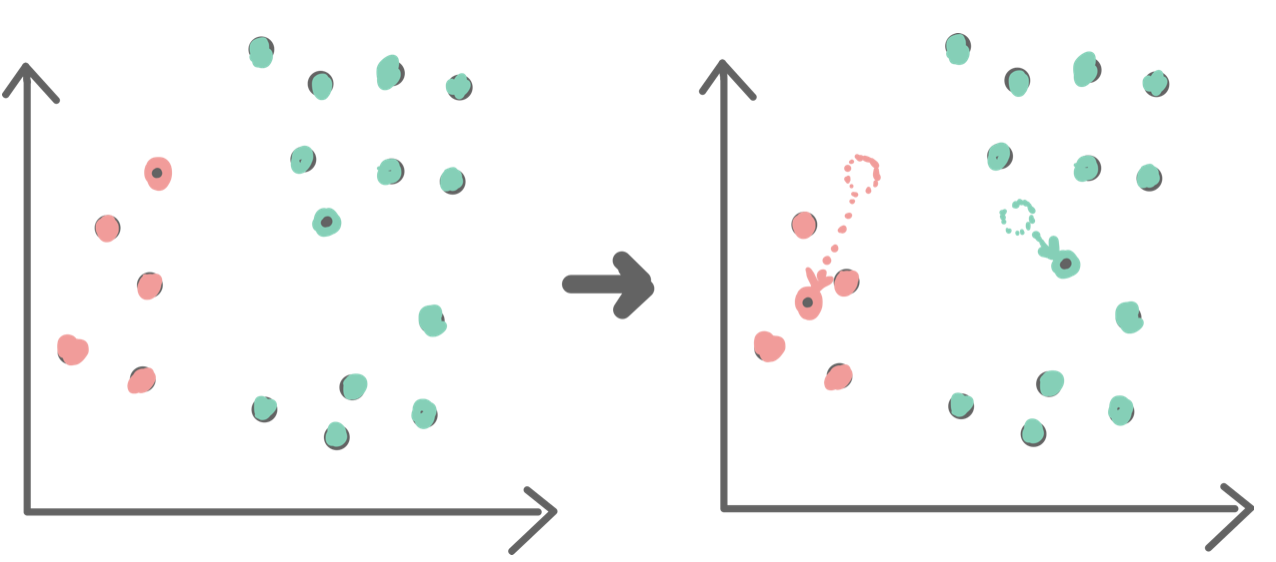

### How does K-means clustering apply to images?

We stored our BGR images as 3D arrays. So, we can represent one as a 3D scatterplot.

In [ ]:
import plotly.graph_objects as go

samplingFactor = int(np.prod(images[0].shape) / 10000)
colors = [f'rgb({r},{g},{b})' for r, g, b in zip(images[0][:,:,0].flatten()[::samplingFactor], images[0][:,:,1].flatten()[::samplingFactor], images[0][:,:,2].flatten()[::samplingFactor])]

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=images[0][:,:,0].flatten()[::samplingFactor],
            y=images[0][:,:,1].flatten()[::samplingFactor],
            z=images[0][:,:,2].flatten()[::samplingFactor],
            mode='markers',
            marker=dict(
                size=5,
                color=colors,  # Assign colors to each point
                opacity=0.8
            )
        )
    ]
)

fig.show()
plt.imshow(images[0])

The different parts the image (leaves, background) should form clusters. Let's try K-means clustering on this.

In [ ]:
from sklearn.cluster import KMeans

h, w, c = images[0].shape
data = images[0].reshape((-1, c))
kmean = KMeans(n_clusters = 5).fit(data)
labels = kmean.labels_

import plotly.express as px

fig = px.scatter_3d(
        x=images[0][:,:,0].flatten()[::samplingFactor],
        y=images[0][:,:,1].flatten()[::samplingFactor],
        z=images[0][:,:,2].flatten()[::samplingFactor],
        color = labels[::samplingFactor]
  )
fig.show()

Now, if we simplify the image based on its K-means clusters...

In [ ]:
centers = kmean.cluster_centers_.astype(int)
newImage = centers[labels].reshape((h, w, c))
plt.imshow(newImage)

### Question
You can change the number of clusters `k` in the `Kmeans()` function using the `n_clusters` argument. Play around with a few different `k` values in the code below. What number of clusters do you think best isolates the plant while excluding the background?


In [ ]:
k = 5
i = 0

h, w, c = images[i].shape
data = images[i].reshape((-1, c))
kmean = KMeans(n_clusters = k).fit(data)
labels = kmean.labels_
centers = kmean.cluster_centers_.astype(int)
centers
newImage = centers[labels].reshape((h, w, c))
plt.imshow(newImage)

### Using the best number of clusters `k`, we can now binarize the image (keep in mind that here "binarize" means convert to 0s and 255s, not 0s and 1s).

In [ ]:
binaryImages = []
for image in images:
  plt.figure()
  plt.imshow(image)
  plt.pause(0.0001)
  h, w, c = image.shape
  data = image.reshape((-1, c))
  kmean = KMeans(n_clusters = k).fit(data)
  labels = kmean.labels_
  centers = np.array([0,255])
  binaryImage = centers[labels].reshape(h, w).astype("uint8")
  binaryImages.append(binaryImage)
  plt.figure()
  plt.imshow(binaryImage, cmap='gray')
  plt.pause(0.0001)

### Now we can extract contours ("islands" of 1s or 0s) using OpenCV's `cv2.findContours()` and filter them based on size. How do the segmented components look?

In [ ]:
import copy

def cropSquareFromContour(c, img):

    rect = cv2.minAreaRect(c)
    rect = list(rect)
    rect[1] = (max(rect[1]), max(rect[1]))

    box = cv2.boxPoints(rect)
    box = np.intp(box)
    width = int(max(rect[1]))
    height = int(max(rect[1]))

    src_pts = box.astype("float32")
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, M, (width, height))

    return warped

for i, binaryImage in enumerate(binaryImages[0:15]):
  plt.figure()
  plt.imshow(images[i])
  plt.figure()
  plt.imshow(binaryImage)
  contours, _ = cv2.findContours(binaryImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  annotatedImage = copy.deepcopy(images[i])
  for contour in contours:
    canvas = np.zeros(binaryImage.shape).astype("uint8")
    canvas = cv2.drawContours(canvas, [contour], -1, 255, cv2.FILLED)
    leafMask = cropSquareFromContour(contour, canvas)
    leaf = cropSquareFromContour(contour, images[i])
    leaf[(255 - leafMask).astype("bool"), :] = [255,255,255]
    annotatedImage = cv2.drawContours(annotatedImage, [contour], -1, (0,255,0), 5)
    plt.figure()
    plt.imshow(leaf)
    plt.pause(0.0001)

  plt.figure()
  plt.imshow(annotatedImage)
  plt.pause(0.0001)

### Question: We need to get rid of tiny segmentations. We can do this using either a convolution that removes isolated pixels, or by filtering only large contours. Modify the code below to get rid of tiny segmentations. Relevant functions: `cv2.erode()`, `cv2.dilate()`, `cv2.contourArea()`.

In [ ]:
import copy

def cropSquareFromContour(c, img):

    rect = cv2.minAreaRect(c)
    rect = list(rect)
    rect[1] = (max(rect[1]), max(rect[1]))

    box = cv2.boxPoints(rect)
    box = np.intp(box)
    width = int(max(rect[1]))
    height = int(max(rect[1]))

    src_pts = box.astype("float32")
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, M, (width, height))

    return warped

for i, binaryImage in enumerate(binaryImages[0:15]):
  plt.figure()
  plt.imshow(images[i])
  plt.figure()
  plt.imshow(binaryImage)
  contours, _ = cv2.findContours(binaryImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  annotatedImage = copy.deepcopy(images[i])
  for contour in contours:
    canvas = np.zeros(binaryImage.shape).astype("uint8")
    canvas = cv2.drawContours(canvas, [contour], -1, 255, cv2.FILLED)
    leafMask = cropSquareFromContour(contour, canvas)
    leaf = cropSquareFromContour(contour, images[i])
    leaf[(255 - leafMask).astype("bool"), :] = [255,255,255]
    annotatedImage = cv2.drawContours(annotatedImage, [contour], -1, (0,255,0), 5)
    plt.figure()
    plt.imshow(leaf)
    plt.pause(0.0001)

  plt.figure()
  plt.imshow(annotatedImage)
  plt.pause(0.0001)

# How to train a machine learning model in 2 minutes

### We'll use [Google Teacheable Machine](https://teachablemachine.withgoogle.com/train/image) to quickly train a MobileNet CNN ([convolutional neural network](https://playground.tensorflow.org/)) to distinguish between the segmented objects in our images.



Defining a function to get inference from our machine learning model.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image, ImageOps

modelDirectory = "/content/ANS128/data/leafClassifier/model.savedmodel"
model = tf.keras.layers.TFSMLayer(modelDirectory, call_endpoint='serving_default')
labels = open("/content/ANS128/data/leafClassifier/labels.txt", "r").readlines()
labels = np.array([line.split(' ', 1)[1].strip() for line in labels])

def classifyImage(cv2Image):
  img = cv2Image
  img = Image.fromarray(img)
  width_height_tuple = (224, 224)
  width, height = img.size
  target_width, target_height = width_height_tuple
  crop_height = (width * target_height) // target_width
  crop_width = (height * target_width) // target_height
  crop_height = min(height, crop_height)
  crop_width = min(width, crop_width)
  crop_box_hstart = (height - crop_height) // 2
  crop_box_wstart = (width - crop_width) // 2
  crop_box_wend = crop_box_wstart + crop_width
  crop_box_hend = crop_box_hstart + crop_height
  crop_box = [
      crop_box_wstart, crop_box_hstart, crop_box_wend,
      crop_box_hend
  ]
  img = img.resize(width_height_tuple, Image.NEAREST, box=crop_box)
  my_image = img_to_array(img)
  my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
  my_image = my_image / 255.
  prediction = model(my_image)['sequential_3'].numpy()
  return(prediction)

### View an inference for one leaf

The output of the classifier model is a vector of "confidences" for each class. Is the model still working, now that we're using it via Python rather than through the web app? Test some different images from the `testingLeaves` folder.

In [ ]:
leaf = cv2.imread("/content/ANS128/data/testingLeaves/0_0.png")
plt.imshow(leaf)
plt.title(classifyImage(leaf))

### Question
Edit the segmentation loop above to get counts of each type of leaf from each image. This will involve two steps:

*   Convert the classifier model output (a vector of numbers) to a string representing the most likely classification.
*   For each image in the segmentation loop above, tally up the count for each class of leaf.



# Sandbox: upload your own images and try segmenting or classifying them.